# Programming Assignment: 1NN против RandomForest

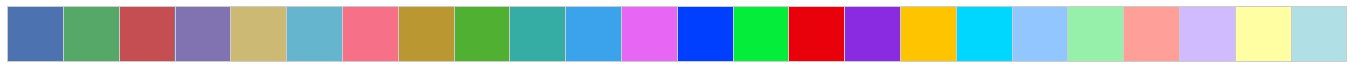

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as sts
import seaborn as sns
from contextlib import contextmanager

sns.set()
sns.set_style("whitegrid")

color_palette = sns.color_palette('deep') + sns.color_palette('husl', 6) + sns.color_palette('bright') + sns.color_palette('pastel')

%matplotlib inline
sns.palplot(color_palette)

def ndprint(a, precision=3):
    with np.printoptions(precision=precision, suppress=True):
        print(a)

In [2]:
from sklearn import datasets, metrics, model_selection as mdsel, tree, ensemble, neighbors

В этом задании будет использоваться датасет digits из sklearn.datasets. Оставьте последние 25% объектов для контроля качества, разделив X и y на X_train, y_train и X_test, y_test.

Целью задания будет реализовать самый простой метрический классификатор — метод ближайшего соседа, а также сравнить качество работы реализованного вами 1NN с RandomForestClassifier из sklearn на 1000 деревьях.

In [3]:
digits_data = datasets.load_digits()

In [4]:
digits_data['images'].shape, digits_data['data'].shape, digits_data['target'].shape, digits_data['target_names']

((1797, 8, 8), (1797, 64), (1797,), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

In [6]:
digits_X, digits_y = datasets.load_digits(return_X_y=True)

In [7]:
digits_X[:1], digits_y[:5]

(array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
         15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
         12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
          0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
         10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.]]),
 array([0, 1, 2, 3, 4]))

In [39]:
X_train, X_test, y_train, y_test = mdsel.train_test_split(digits_X, digits_y, test_size=0.25, shuffle=False, stratify=None)

#### Задание 1

Реализуйте самостоятельно метод одного ближайшего соседа с евклидовой метрикой для задачи классификации. Можно не извлекать корень из суммы квадратов отклонений, т.к. корень — монотонное преобразование и не влияет на результат работы алгоритма.

Никакой дополнительной работы с признаками в этом задании делать не нужно — мы еще успеем этим заняться в других курсах. Ваша реализация может быть устроена следующим образом: можно для каждого классифицируемого объекта составлять список пар (расстояние до точки из обучающей выборки, метка класса в этой точке), затем сортировать этот список (по умолчанию сортировка будет сначала по первому элементу пары, затем по второму), а затем брать первый элемент (с наименьшим расстоянием).

Сортировка массива длиной N требует порядка N log N сравнений (строже говоря, она работает за O(N log N)). Подумайте, как можно легко улучшить получившееся время работы. Кроме простого способа найти ближайший объект всего за N сравнений, можно попробовать придумать, как разбить пространство признаков на части и сделать структуру данных, которая позволит быстро искать соседей каждой точки. За выбор метода поиска ближайших соседей в KNeighborsClassifier из sklearn отвечает параметр algorithm — если у вас уже есть некоторый бэкграунд в алгоритмах и структурах данных, вам может быть интересно познакомиться со структурами данных ball tree и kd tree.

Доля ошибок, допускаемых 1NN на тестовой выборке, — ответ в задании 1.

In [40]:
def get_squares(a):
    return (a ** 2).sum(axis=1).reshape(1, -1)

X_train_sq = get_squares(X_train)
X_test_sq = get_squares(X_test)

In [41]:
X_train.shape, X_train_sq.shape

((1347, 64), (1, 1347))

In [42]:
from sklearn.metrics.pairwise import euclidean_distances
distances = euclidean_distances(X_train, X_test, X_norm_squared=X_train_sq, Y_norm_squared=X_test_sq).T

In [43]:
distances[:2, :2]

array([[41.12177039, 52.9905652 ],
       [53.70288633, 46.40043103]])

In [44]:
predictions = y_train[np.argmin(distances, axis=1)]
knn_result = 1. - metrics.accuracy_score(y_test, predictions)
knn_result

0.0377777777777778

In [45]:
def write_answer(result, ans_ind):
    path = f'out/23_knn{ans_ind}.txt'
    result_str = result if isinstance(result, str) else str(result)
    with open(path, "w") as fout:
        fout.write(result_str)

In [46]:
write_answer(knn_result, 1)

#### Задание 2

Теперь обучите на обучающей выборке RandomForestClassifier(n_estimators=1000) из sklearn. Сделайте прогнозы на тестовой выборке и оцените долю ошибок классификации на ней. Эта доля — ответ в задании 2. Обратите внимание на то, как соотносится качество работы случайного леса с качеством работы, пожалуй, одного из самых простых методов — 1NN. Такое различие — особенность данного датасета, но нужно всегда помнить, что такая ситуация тоже может иметь место, и не забывать про простые методы.

In [47]:
estimator = ensemble.RandomForestClassifier(n_estimators=1000)
estimator.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [48]:
predictions = estimator.predict(X_test)
rfc_result = 1. - metrics.accuracy_score(y_test, predictions)
rfc_result

0.06000000000000005

In [49]:
write_answer(rfc_result, 2)